In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import time
mpl.rcParams["figure.facecolor"] = "white" # Set figure background to white for notebook with dark mode


def correlation_function(distance,i=2):
    """Exponential correlation function."""
    return np.exp(-distance**i)

def compute_correlation_matrix(grid,kernel, bx,by):
    """Compute the correlation matrix for a 2D grid."""
    N = grid.shape[0]
    C = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d = np.sqrt(((grid[i, 0] - grid[j, 0])/bx)**2 + ((grid[i, 1] - grid[j, 1])/by)**2)
            C[i, j] = kernel(d)
    return C


def KL_expansion(grid, kernel, C_param,truncation_order):
    """Compute the KL expansion."""
    N = grid.shape[0]
    mu = C_param[0]
    sigma = C_param[1]
    bx = C_param[2]
    by = C_param[3]
    C = compute_correlation_matrix(grid, kernel, bx, by)
    eig_values, eig_vectors = np.linalg.eigh(C)
    # Sort eigenvalues and eigenvectors
    idx = eig_values.argsort()[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    return eig_values[:truncation_order], eig_vectors[:, :truncation_order]

C11param = [ 1.55, 0.129, 50, 50]   # = [ mu, sigma , bx, by] 
C33param = [ 0.316, 0.027, 50, 50]

# Parameters
N = 27
Lmax = 100

# Create 2D grid
x = np.linspace(0, Lmax, N)
y = np.linspace(0, Lmax, N)
X, Y = np.meshgrid(x, y)
grid = np.column_stack((X.ravel(), Y.ravel()))

# Spectral decomposition
eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, N**2)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, N**2)

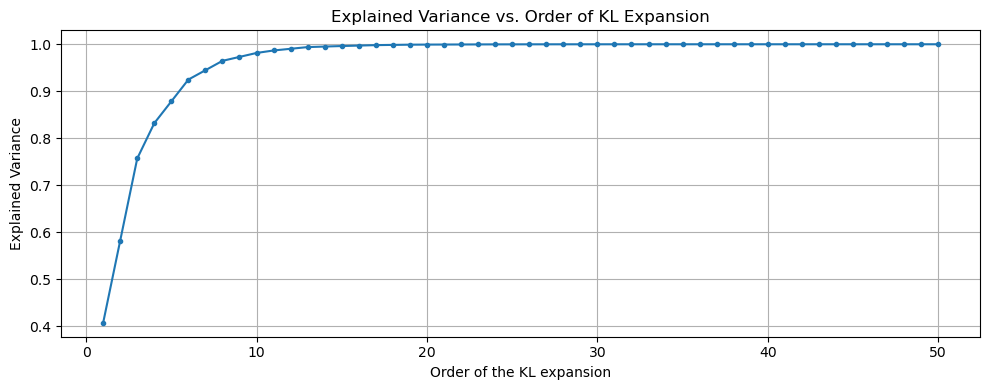

Truncation order for 95.0% explained variance: 8


In [37]:
explained_variance = np.cumsum(eig_values_C11) / np.sum(eig_values_C11)
plt.figure(figsize=(10, 4))
n_orders = 50
plt.plot(np.arange(1, n_orders + 1), explained_variance[:n_orders], marker='.')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Order of KL Expansion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Propose truncation order based on a threshold
threshold = 0.95  # Example threshold for 99% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"Truncation order for {threshold*100}% explained variance: {truncation_order}")


In [38]:
#plotting utility function

def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

Text(0.5, 1.15, 'First 8 Modes of the KL Expansion for C11')

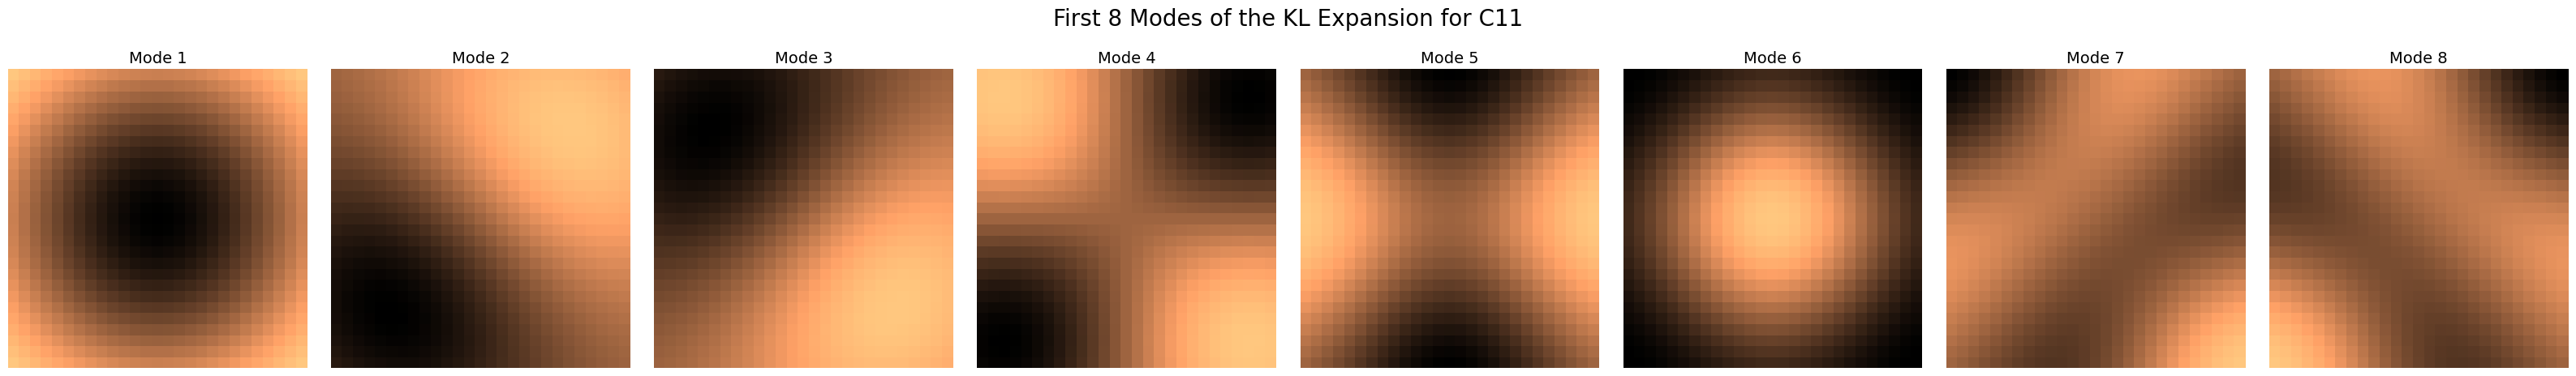

In [39]:
eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, truncation_order)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, truncation_order)

# Plot first modes
fig, ax = plt.subplots(1, 8, figsize=(32, 4))
for i in range(8):
    im = pcolor_plot(ax[i], X, Y, eig_vectors_C11[:, i].reshape((27,27)), f"Mode {i+1}")
plt.tight_layout()
plt.suptitle('First 8 Modes of the KL Expansion for C11', fontsize=20, y=1.15)

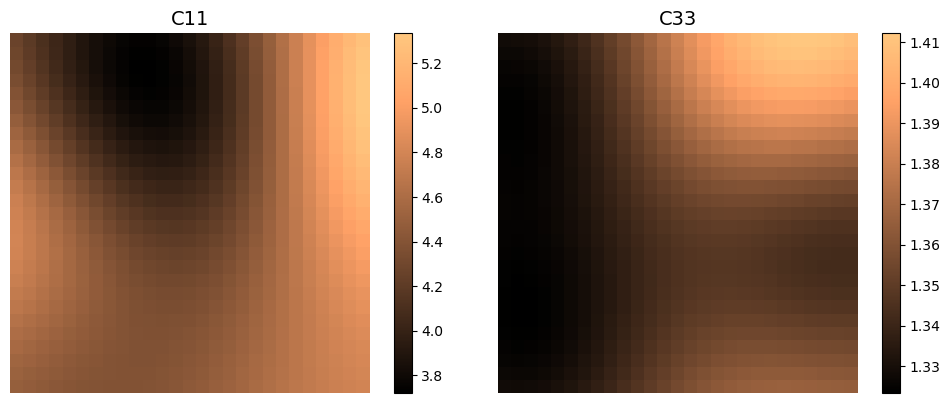

In [40]:
# Simulate Gaussian Random Field using K-L expansion

def C_from_xi(xi, eig_values, eig_vectors, C_param):
    """Compute the Gaussian Random Field from the KL expansion."""
    N = int(np.sqrt(eig_vectors.shape[0]))
    Nsim = xi.shape[0]
    XC = eig_vectors @ (np.sqrt(eig_values) * xi).T
    C = np.exp(C_param[0] + C_param[1] * XC)
    C = C.reshape((N, N, Nsim))
    return C

def dC_from_xi(xi, eig_values, eig_vectors, eig_vectors_dx, eig_vectors_dy, C_param):
    """Compute the gradient of the Gaussian Random Field from the KL expansion."""
    N = int(np.sqrt(eig_vectors.shape[0]))
    Nsim = xi.shape[0]
    XC = eig_vectors @ (np.sqrt(eig_values) * xi).T
    dXC_dx = eig_vectors_dx @ (np.sqrt(eig_values) * xi).T
    dXC_dy = eig_vectors_dy @ (np.sqrt(eig_values) * xi).T
    dC_dx = C_param[1] * dXC_dx * np.exp(C_param[0] + C_param[1] * XC)
    dC_dy = C_param[1] * dXC_dy * np.exp(C_param[0] + C_param[1] * XC)
    return dC_dx.reshape((N, N, Nsim)), dC_dy.reshape((N, N, Nsim))

U_C11 = np.random.randn(1,truncation_order)
U_C33 = np.random.randn(1,truncation_order)

# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

# Visualization
fig,ax = plt.subplots(1,2,figsize=(10,4))

imC11 = pcolor_plot(ax[0], X, Y, C11[:,:,0], "C11")
fig.colorbar(imC11, ax=ax[0])
imC33 = pcolor_plot(ax[1], X, Y, C33[:,:,0], "C33")
fig.colorbar(imC33, ax=ax[1])
plt.tight_layout()

In [94]:
from scipy.interpolate import RegularGridInterpolator

# Function to calculate the derivative using the interpolated function
def derivative_interp(interp_func, x, y, axis, bounds,delta=1e-6):
    if axis == 'x':
        if x - delta < bounds[0] :
            return (interp_func((x + delta, y)) - interp_func((x, y))) / (delta)
        elif x + delta > bounds[1]:
            return (interp_func((x, y)) - interp_func((x - delta, y))) / (delta)
        else:
            return (interp_func((x + delta, y)) - interp_func((x - delta, y))) / (2 * delta)
    elif axis == 'y':
        if y - delta < bounds[0]:
            return (interp_func((x, y + delta)) - interp_func((x, y))) / (delta)
        elif y + delta > bounds[1]:
            return (interp_func((x, y)) - interp_func((x, y - delta))) / (delta)
        else:
            return (interp_func((x, y + delta)) - interp_func((x, y - delta))) / (2 * delta)

def calculate_derivatives(C):
    x = np.linspace(0, Lmax, C.shape[0])
    y = np.linspace(0, Lmax, C.shape[1])

    N = C.shape[0]
    C_dx = np.zeros_like(C)
    C_dy = np.zeros_like(C)

    for i in range(C.shape[2]):
        C_matrix = C[:,:,i].squeeze()
        C_interp = RegularGridInterpolator((x, y), C_matrix.T, method='cubic')
        # C_interp = lambda x: interp2d(x[0], x[1], C_matrix, kind='cubic')

        for j in range(N):
            for k in range(N):
                C_dx[j, k,i] = derivative_interp(C_interp, x[k], y[j], 'x',bounds=[0,Lmax]) 
                C_dy[j, k,i] = derivative_interp(C_interp, x[k], y[j], 'y',bounds=[0,Lmax])
    
    return C_dx, C_dy

# Calculate the derivatives of the eigenfunctions
eig_vectors_C11_dx, eig_vectors_C11_dy = calculate_derivatives(eig_vectors_C11.reshape((N,N,truncation_order)))
eig_vectors_C11_dx = eig_vectors_C11_dx.reshape((N**2,truncation_order))
eig_vectors_C11_dy = eig_vectors_C11_dy.reshape((N**2,truncation_order))
eig_vectors_C33_dx, eig_vectors_C33_dy = calculate_derivatives(eig_vectors_C33.reshape((N,N,truncation_order)))
eig_vectors_C33_dx = eig_vectors_C33_dx.reshape((N**2,truncation_order))
eig_vectors_C33_dy = eig_vectors_C33_dy.reshape((N**2,truncation_order))

t_start = time.time()
# Calculate derivatives on the grid
C11_dx, C11_dy = calculate_derivatives(C11)
C33_dx, C33_dy = calculate_derivatives(C33)
t_derivative = time.time() - t_start

# Calculate derivatives from the KL expansion derivatived eigenfunctions
C11_dx_KL, C11_dy_KL = dC_from_xi(U_C11, eig_values_C11, eig_vectors_C11, eig_vectors_C11_dx, eig_vectors_C11_dy, C11param)
C33_dx_KL, C33_dy_KL = dC_from_xi(U_C33, eig_values_C33, eig_vectors_C33, eig_vectors_C33_dx, eig_vectors_C33_dy, C33param)
t_KLderivative = time.time() - t_start - t_derivative

print(f"Time for derivative on grid: {t_derivative:.2f}s vs {t_KLderivative:.6f}s for KL expansion")

#compare the derivatives
residual_C11_dx = np.abs(C11_dx - C11_dx_KL)
residual_C11_dy = np.abs(C11_dy - C11_dy_KL)
residual_C33_dx = np.abs(C33_dx - C33_dx_KL)
residual_C33_dy = np.abs(C33_dy - C33_dy_KL)

print(f"Maximum residual for C11_dx: {np.max(residual_C11_dx):.2e} ; relative: {np.max(residual_C11_dx)/np.max(np.abs(C11_dx)):.2e}")
print(f"Maximum residual for C11_dy: {np.max(residual_C11_dy):.2e} ; relative: {np.max(residual_C11_dy)/np.max(np.abs(C11_dy)):.2e}")
print(f"Maximum residual for C33_dx: {np.max(residual_C33_dx):.2e} ; relative: {np.max(residual_C33_dx)/np.max(np.abs(C33_dx)):.2e}")
print(f"Maximum residual for C33_dy: {np.max(residual_C33_dy):.2e} ; relative: {np.max(residual_C33_dy)/np.max(np.abs(C33_dy)):.2e}")

Time for derivative on grid: 404.15s vs 0.009002s for KL expansion
Maximum residual for C11_dx: 5.57e-05 ; relative: 9.62e-04
Maximum residual for C11_dy: 8.39e-05 ; relative: 1.33e-03
Maximum residual for C33_dx: 6.40e-07 ; relative: 1.62e-04
Maximum residual for C33_dy: 6.92e-07 ; relative: 1.79e-04


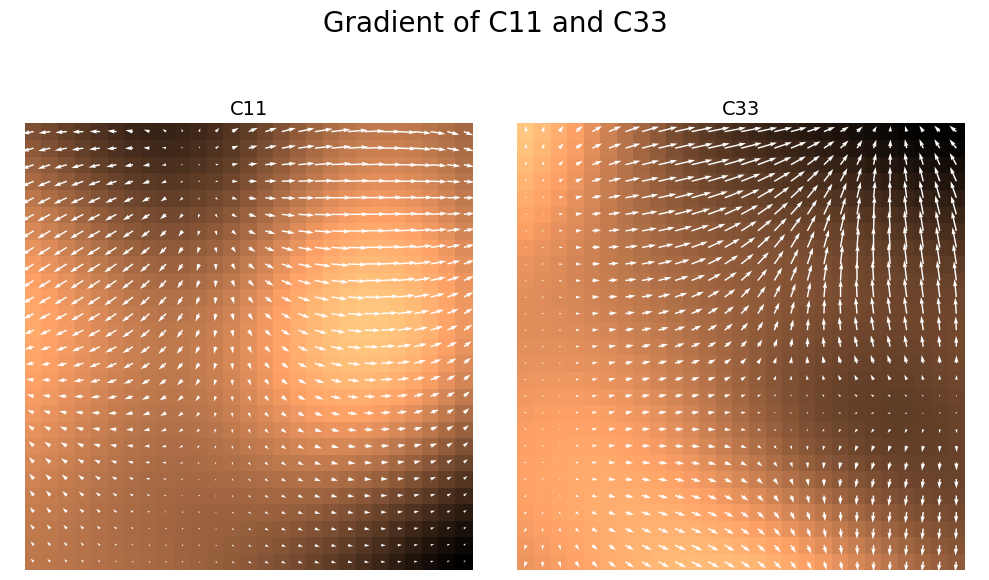

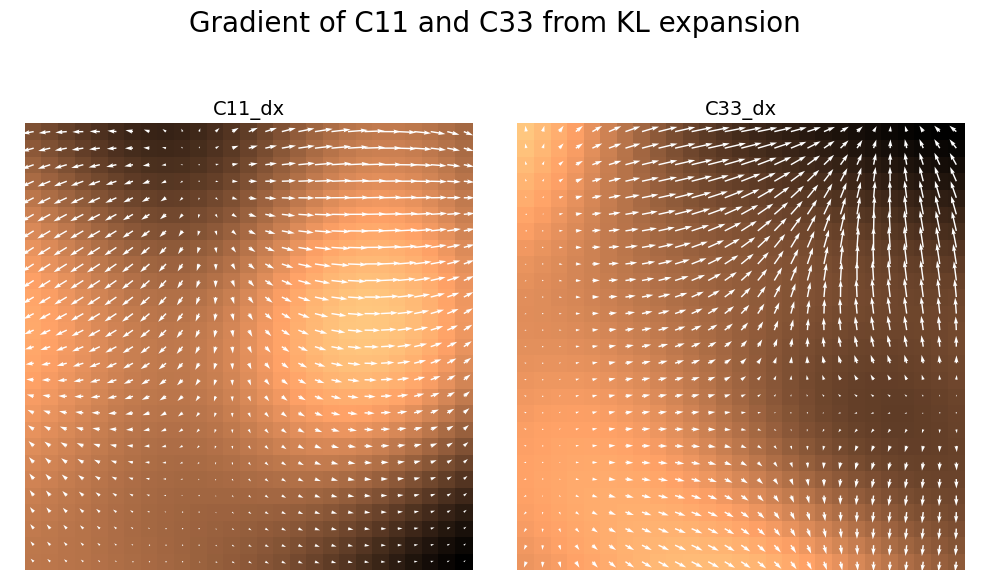

In [93]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

imC11 = pcolor_plot(ax[0], X, Y, C11[:,:,0], "C11")
imC33 = pcolor_plot(ax[1], X, Y, C33[:,:,0], "C33")
plt.tight_layout()
plt.suptitle('Gradient of C11 and C33', fontsize=20, y=1.15)

# Plot the gradient of the Gaussian Random Field
scale_C11 = max(np.max(np.abs(C11_dx)), np.max(np.abs(C11_dy)))*20/Lmax # Scale factor for the gradient
scale_C33 = max(np.max(np.abs(C33_dx)), np.max(np.abs(C33_dy)))*20/Lmax # Scale factor for the gradient

for j in range(N):
    for k in range(N):
        ax[0].quiver(X[j, k], Y[j, k], C11_dx[j, k] , C11_dy[j, k], 
                  color='white', scale=scale_C11, scale_units='xy', angles='xy', width=0.003)
        ax[1].quiver(X[j, k], Y[j, k], C33_dx[j, k], C33_dy[j, k], 
                  color='white', scale=scale_C33, scale_units='xy', angles='xy', width=0.003)
        
# # Plot the gradient of the Gaussian Random Field from the KL expansion
fig,ax = plt.subplots(1,2,figsize=(10,5))

imC11 = pcolor_plot(ax[0], X, Y, C11[:,:,0], "C11_dx")
imC33 = pcolor_plot(ax[1], X, Y, C33[:,:,0], "C33_dx")
plt.tight_layout()
plt.suptitle('Gradient of C11 and C33 from KL expansion', fontsize=20, y=1.15)

# Plot the gradient of the Gaussian Random Field
scale_C11_KL = max(np.max(np.abs(C11_dx_KL)), np.max(np.abs(C11_dy_KL)))*20/Lmax # Scale factor for the gradient
scale_C33_KL = max(np.max(np.abs(C33_dx_KL)), np.max(np.abs(C33_dy_KL)))*20/Lmax # Scale factor for the gradient

for j in range(N):
    for k in range(N):
        ax[0].quiver(X[j, k], Y[j, k], C11_dx_KL[j, k] , C11_dy_KL[j, k], 
                  color='white', scale=scale_C11_KL, scale_units='xy', angles='xy', width=0.003)
        ax[1].quiver(X[j, k], Y[j, k], C33_dx_KL[j, k], C33_dy_KL[j, k], 
                  color='white', scale=scale_C33_KL, scale_units='xy', angles='xy', width=0.003)


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import skopt


# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0][:, None, i].flatten()
print("Using GPU:", torch.cuda.is_available())

Using GPU: True


In [44]:
def E_nn(U,X):
    #calculate the strain given the displacement
    # u is the output of the NN, a tensor of shape (N,2)
    Exx = grad_i(U[0],X,0)
    Eyy = grad_i(U[1],X,1)
    Exy = 0.5 * (grad_i(U[1],X,0) +grad_i(U[0],X,1))
    return [Exx, Eyy, Exy]

def S_nn(E, C11, C33):
    Exx, Eyy, Exy = E
    Sxx = C11 * (Exx + Eyy) - 2*C33 * Eyy
    Syy = C11 * (Exx + Eyy) - 2*C33 * Exx
    Sxy = 2*C33 * Exy

    return [Sxx, Syy, Sxy]

def compute_PDE(X, E, C_data):

    C11, dC11_dx, dC11_dy,C33,dC33_dx, dC33_dy = C_data
    Exx, Eyy, Exy = E 

    # Sxx, Syy, Sxy = S_nn(E, C11, C33)
    # dSxx_dx = grad_i(Sxx,X,0)
    # dSyy_dy = grad_i(Syy,X,1)
    # dSxy_dx = grad_i(Sxy,X,0)
    # dSxy_dy = grad_i(Sxy,X,1)

    # Mx = dSxx_dx + dSxy_dy
    # My = dSyy_dy + dSxy_dx 
    dExx_dx = grad_i(Exx,X,0)
    dExx_dy = grad_i(Exx,X,1)
    dEyy_dx = grad_i(Eyy,X,0)
    dEyy_dy = grad_i(Eyy,X,1)
    dExy_dx = grad_i(Exy,X,0)
    dExy_dy = grad_i(Exy,X,1)
 
    Mx = dC11_dx * (Exx + Eyy) + C11 * (dExx_dx + dEyy_dx) - 2*dC33_dx * Eyy - 2*C33 * dEyy_dx + 2*dC33_dy * Exy + 2*C33 * dExy_dy
    My = dC11_dy * (Exx + Eyy) + C11 * (dExx_dy + dEyy_dy) - 2*dC33_dy * Exx - 2*C33 * dExx_dy + 2*dC33_dx * Exy + 2*C33 * dExy_dx

    return [Mx, My]


def Enforce_BC(x,Ux,Uy):

    Ux = Ux*x[:,0]
    Uy = Uy*x[:,1]
    return [Ux,Uy]


def static_sampling(domain,n_samples, sampling_strat):
    """Generate a static sampling strategy for the domain.
    "random","LHS" are stochastic
    "grid","Halton","Hammersley","Sobol" are deterministic
    Parameters
    ----------
    domain:[[XMIN, XMAX], [YMIN, YMAX]]
        The domain of the problem.
    n_samples: int
        The number of samples.
    sampling_strat: str
        The sampling strategy.
    Returns
    -------
    X: numpy.ndarray
        The generated samples.
    """
    if sampling_strat == "Random":
        X = np.random.uniform(domain[0][0], domain[0][1], n_samples)
        Y = np.random.uniform(domain[1][0], domain[1][1], n_samples)
        X = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        return X
    elif sampling_strat == "Grid":
        X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_samples)))
        Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_samples)))
        X, Y = np.meshgrid(X, Y)
        X = X.reshape(-1, 1)
        Y = Y.reshape(-1, 1)
        X = np.hstack((X, Y))
        return X
     
    elif sampling_strat == "LHS":
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000)
    elif sampling_strat == "Halton":
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)
    elif sampling_strat == "Hammersley":
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
    elif sampling_strat == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which
        # are too special and may cause some error.
        sampler = skopt.sampler.Sobol(skip=0, randomize=False)
        return np.array(sampler.generate(domain, n_samples + 2)[2:])
    return np.array(sampler.generate(domain, n_samples))

def adaptative_sampling(self,domain,n_samples,loss_function,existing_sample=None, k=1, c=1):
    
    if existing_sample is None:
        X_previous = torch.tensor(static_sampling(domain,n_samples, "Hammersley"), dtype=torch.float32, device=self.device)
    else:
        X_previous = existing_sample

    X = static_sampling(domain,100000, "Random")
    X_torch = torch.tensor(X, dtype=torch.float32, device=device)
    X_torch.requires_grad = True
    loss = loss_function(X_torch).detach().cpu().numpy()
    loss += min(loss)

    err_eq = np.power(loss, k) / np.power(loss, k).mean() + c
    err_eq_normalized = (err_eq / sum(err_eq))
    X_ids = np.random.choice(a=len(X), size=int(n_samples/10), replace=False, p=err_eq_normalized)
    X_new =  torch.tensor(X[X_ids,:], dtype=torch.float32, device=self.device)
    return torch.cat((X_previous,X_new))


In [45]:
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=100, output_dim=1):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class CoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(CoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
def U_nn(x, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC,N=27**2):
    """Compute the total predicted u."""
    x_unique = x[:N,:]

    pce_basis = hermite_polynomial(1, xi)
    Ux = Ux_mean(x).flatten() + (Ux_coeffs(x_unique) @ pce_basis.T).T.flatten()  
    Uy = Uy_mean(x).flatten() + (Uy_coeffs(x_unique) @ pce_basis.T).T.flatten()
    Ux, Uy = Enforce_BC(x,Ux,Uy)
    return [Ux, Uy]

def l2_regularization(model):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

def U_exact(X,delta=0):
    Ux = 0.025712*X[:,0]+delta*torch.cos(np.pi*X[:,0]/Lmax)
    Uy = -0.010741*X[:,1]+delta*torch.cos(np.pi*X[:,1]/Lmax)
    return [Ux,Uy]

def compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data, C_data_bc, batch_size,pstress=0.1,N=27):

    N_sim = xi.size(0)
    indices = torch.randperm(N_sim)[:batch_size]
    xi_batch = xi[indices]

    U_pde = U_nn(x_pde, xi_batch, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC,N**2)
    E_pde = E_nn(U_pde,x_pde)


    # Compute the stress
    pde_indices = np.repeat(indices*N**2,N**2) + np.tile(np.array(range(N**2)),batch_size)
    C_data_batch = [C[pde_indices] for C in C_data]

    bc_indices = np.repeat(indices*N,N) + np.tile(np.array(range(N)),batch_size)
    C_data_batch_bc = [C[bc_indices] for C in C_data_bc]

    Mx,My = compute_PDE(x_pde, E_pde, C_data_batch)

    pde_loss = torch.mean((Mx**2 + My**2))
    # Boundary Conditions Loss on stress
    U_bc_stress = U_nn(x_bcs[0], xi_batch, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC,N)
    E_bc_stress = E_nn(U_bc_stress,x_bcs[0])
    S_bc_stress = S_nn(E_bc_stress, C_data_batch_bc[0], C_data_batch_bc[1])
    bc_loss_stress = torch.mean((S_bc_stress[0] - pstress)**2)
    
    U_bc_free = U_nn(x_bcs[1], xi_batch, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC,N)
    E_bc_free = E_nn(U_bc_free,x_bcs[1])
    S_bc_free = S_nn(E_bc_free, C_data_batch_bc[2], C_data_batch_bc[3])
    bc_loss_free = torch.mean((S_bc_free[1])**2)


    # Combine the losses
    bc_loss = bc_loss_stress + bc_loss_free
    U_pde_exact = U_exact(x_pde)
    residual_loss = torch.mean((U_pde[0] - U_pde_exact[0])**2 + (U_pde[1] - U_pde_exact[1])**2)
    
    return pde_loss, bc_loss, residual_loss

In [46]:
def train(Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, xi, C_data, C_data_bc, batch_size=100, epochs=1000, lr=0.001, lambda_reg=1e-4,lambda_bc=1, N = 27,sampling = 'Grid',pstress=0.1,opt='Adam',print_every=100,models_to_train_type = ['mean','coeffs']):
    device = xi.device
    t_start = time.perf_counter()
    x_pde = torch.tensor(static_sampling([[0, Lmax], [0, Lmax]], N**2, sampling)).float().to(device).repeat(batch_size,1)
    x_pde.requires_grad = True

    x_bc_stress = torch.ones((N,2))*Lmax
    x_bc_stress[:,1] = torch.linspace(0,Lmax,N).float()
    x_bc_stress = x_bc_stress.to(device).repeat(batch_size,1)
    x_bc_stress.requires_grad = True
    

    x_bc_free = torch.ones((N,2))*Lmax
    x_bc_free[:,0] = torch.linspace(0,Lmax,N).float()
    x_bc_free = x_bc_free.to(device).repeat(batch_size,1)
    x_bc_free.requires_grad = True

    x_bcs = [x_bc_stress,x_bc_free]

    models_to_train = []
    parameters_to_train = []
    if 'mean' in models_to_train_type:
        models_to_train += [Ux_mean,Uy_mean]
        parameters_to_train += list(Ux_mean.parameters()) + list(Uy_mean.parameters()) 

    if 'coeffs' in models_to_train_type:
        models_to_train += [Ux_coeffs,Uy_coeffs]
        parameters_to_train += list(Ux_coeffs.parameters()) + list(Uy_coeffs.parameters())
    # parameters_to_train = [model.parameters() for model in models_to_train]

    if opt == 'Adam':
        optimizer = torch.optim.Adam(parameters_to_train, lr=lr)

        for epoch in range(epochs):
            optimizer.zero_grad()
            
            pde_loss,bc_loss,residual_loss = compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data,C_data_bc, batch_size,pstress=pstress,N=N)
            l2_reg = torch.sum(torch.stack([l2_regularization(model) for model in models_to_train]))
            loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss #+ residual_loss
            loss.backward()
            optimizer.step()
            
            # Print progress
            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e},Residual: {residual_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.perf_counter()-t_start:.0f}")

    elif opt == 'LBFGS':
        optimizer = torch.optim.LBFGS(parameters_to_train, lr=lr, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        # optimizer = torch.optim.LBFGS(list(Ux_mean.parameters())+list(Uy_mean.parameters()), lr=lr)
        def closure():
            optimizer.zero_grad()
            pde_loss,bc_loss,residual_loss = compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data,C_data_bc, batch_size,pstress=pstress,N=N)
            l2_reg = torch.sum(torch.stack([l2_regularization(model) for model in models_to_train]))
            loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss
            loss.backward()
            return loss
        for epoch in range(epochs):
            optimizer.step(closure)
            # Print progress
            if epoch % print_every == 0:
                pde_loss,bc_loss,residual_loss = compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data, batch_size,pstress=pstress,N=N)
                l2_reg = torch.sum(torch.stack([l2_regularization(model) for model in models_to_train]))
                print(f"Epoch {epoch}, Loss: {closure().item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e},Residual loss: {residual_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.perf_counter()-t_start:.0f}")
    
    pde_loss,bc_loss,residual_loss = compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data,C_data_bc, batch_size,pstress=pstress,N=N)
    l2_reg = torch.sum(torch.stack([l2_regularization(model) for model in models_to_train]))
    loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss

    print(f"Epoch {epoch}, Loss: {loss.item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e},Residual loss: {residual_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.perf_counter()-t_start:.0f}")
    return Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs


In [101]:
Lmax = 100
N = 27  # Grid of size N x N
Nsim = 1000  # Number of simulations
truncation_order = 8

# Create 2D grid
x = np.linspace(0, Lmax, N)
y = np.linspace(0, Lmax, N)
X, Y = np.meshgrid(x, y)
grid = np.column_stack((X.ravel(), Y.ravel()))

# C11param = [ 1.55, 0, 50, 50]   # = [ mu, sigma , bx, by]
# C33param = [ 0.316, 0, 50, 50]

C11param = [ 1.55, 0.129, 50, 50]   # = [ mu, sigma , bx, by]
C33param = [ 0.316, 0.027, 50, 50]

eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, truncation_order)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, truncation_order)


# Simulate Gaussian Random Field using K-L expansion
U_C11 = np.random.randn(Nsim,truncation_order)
U_C33 = np.random.randn(Nsim,truncation_order)
xi = torch.cat((torch.tensor(U_C11).float(),torch.tensor(U_C33).float()),dim=1).to(device)

# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

# Calculate the derivatives of the eigenfunctions
eig_vectors_C11_dx, eig_vectors_C11_dy = calculate_derivatives(eig_vectors_C11.reshape((N,N,truncation_order)))
eig_vectors_C11_dx = eig_vectors_C11_dx.reshape((N**2,truncation_order))
eig_vectors_C11_dy = eig_vectors_C11_dy.reshape((N**2,truncation_order))
eig_vectors_C33_dx, eig_vectors_C33_dy = calculate_derivatives(eig_vectors_C33.reshape((N,N,truncation_order)))
eig_vectors_C33_dx = eig_vectors_C33_dx.reshape((N**2,truncation_order))
eig_vectors_C33_dy = eig_vectors_C33_dy.reshape((N**2,truncation_order))

C11_bc_stress = C11[:,-1,:]
C33_bc_stress = C33[:,-1,:]
C11_bc_free = C11[-1,:,:]
C33_bc_free = C33[-1,:,:]

C_data_bc = (C11_bc_stress, C33_bc_stress, C11_bc_free, C33_bc_free)
C_data_bc = [C.reshape((N,Nsim)).T.ravel() for C in C_data_bc]
C_data_bc = [torch.tensor(C).float().to(device) for C in C_data_bc]

dC11_dx, dC11_dy = dC_from_xi(U_C11, eig_values_C11, eig_vectors_C11, eig_vectors_C11_dx, eig_vectors_C11_dy, C11param)
dC33_dx, dC33_dy = dC_from_xi(U_C33, eig_values_C33, eig_vectors_C33, eig_vectors_C33_dx, eig_vectors_C33_dy, C33param)

C_data = (C11, dC11_dx, dC11_dy, C33, dC33_dx, dC33_dy)
C_data = [C.reshape((N**2, Nsim)).T.ravel() for C in C_data]
C_data = [torch.tensor(C).float().to(device) for C in C_data]

# Models, Loss, and Optimizer
Ux_mean = MeanNN(input_dim=2).to(device)
Ux_coeffs = CoefficientNN(input_dim=2, output_dim=truncation_order*2).to(device)
Uy_mean = MeanNN(input_dim=2).to(device)
Uy_coeffs = CoefficientNN(input_dim=2, output_dim=truncation_order*2).to(device)

In [104]:
U_C11 = np.zeros_like(U_C11) # for testing --> should be removed
U_C33 = np.zeros_like(U_C33) # for testing --> should be removed


load_models = False
save_folder = "saved_models"
suffix = "_mean"
if load_models:
    Ux_mean.load_state_dict(torch.load(os.path.join(save_folder, f"Ux_mean{suffix}.pt"), map_location=torch.device(device)))
#     Ux_coeffs.load_state_dict(torch.load(os.path.join(save_folder, f"Ux_coeffs{suffix}.pt"), map_location=torch.device(device)))
    Uy_mean.load_state_dict(torch.load(os.path.join(save_folder, f"Uy_mean{suffix}.pt"), map_location=torch.device(device)))
#     Uy_coeffs.load_state_dict(torch.load(os.path.join(save_folder, f"Uy_coeffs{suffix}.pt"), map_location=torch.device(device)))
    print("Models loaded.")
    
# Training
batch_size = 1
opt = ['Adam','LBFGS'][0]
learning_rate = 1e-2
lambda_bc = 1e0
lambda_reg = 1e-3
epochs = 1000
print_every = 100
models_to_train_type = ['mean']
Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs = train(Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, xi, C_data, C_data_bc, batch_size=batch_size, epochs=epochs, lr=learning_rate, lambda_reg=lambda_reg,lambda_bc=lambda_bc,N = 27,sampling = 'Grid',opt=opt,print_every=print_every,models_to_train_type=models_to_train_type)

Epoch 0, Loss: 4.914e+01, PDE loss: 6.248e+00, BC loss: 4.286e+01,Residual: 1.684e+03, l2 reg: 3.370e+01, Elapsed time: 0
Epoch 100, Loss: 2.923e+00, PDE loss: 5.753e-01, BC loss: 2.311e+00,Residual: 5.816e+02, l2 reg: 3.657e+01, Elapsed time: 9
Epoch 200, Loss: 4.294e+00, PDE loss: 2.783e-01, BC loss: 3.980e+00,Residual: 3.619e+02, l2 reg: 3.623e+01, Elapsed time: 20
Epoch 300, Loss: 9.674e+01, PDE loss: 9.351e-01, BC loss: 9.577e+01,Residual: 5.208e+03, l2 reg: 3.668e+01, Elapsed time: 29
Epoch 400, Loss: 3.462e+00, PDE loss: 3.601e-01, BC loss: 3.065e+00,Residual: 7.810e+02, l2 reg: 3.764e+01, Elapsed time: 37
Epoch 500, Loss: 8.385e+00, PDE loss: 2.102e-01, BC loss: 8.137e+00,Residual: 7.996e+02, l2 reg: 3.791e+01, Elapsed time: 47
Epoch 600, Loss: 1.368e+01, PDE loss: 3.035e-01, BC loss: 1.334e+01,Residual: 9.144e+02, l2 reg: 3.907e+01, Elapsed time: 56
Epoch 700, Loss: 1.950e+01, PDE loss: 4.746e-01, BC loss: 1.899e+01,Residual: 1.704e+03, l2 reg: 3.831e+01, Elapsed time: 65
Epoc

In [59]:
import os

# Create the folder if it doesn't exist
save_folder = "saved_models"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

suffix = '_mean'
save_models = True
if save_models:
    torch.save(Ux_mean.state_dict(), os.path.join(save_folder, f"Ux_mean{suffix}.pt"))
    torch.save(Ux_coeffs.state_dict(), os.path.join(save_folder, f"Ux_coeffs{suffix}.pt"))
    torch.save(Uy_mean.state_dict(), os.path.join(save_folder, f"Uy_mean{suffix}.pt"))
    torch.save(Uy_coeffs.state_dict(), os.path.join(save_folder, f"Uy_coeffs{suffix}.pt"))
    print("Models saved.")

Models saved.


In [86]:
#load matlab monte carlo data
import scipy.io as sio
Ux_samples = sio.loadmat('./matlab/Ux_samples.mat')['ux_data']
Uy_samples = sio.loadmat('./matlab/Uy_samples.mat')['uy_data']
N_mc = int(np.sqrt(Ux_samples.shape[0]))
Nsim_mc = Ux_samples.shape[1]
Ux_samples = np.transpose(Ux_samples.reshape((N_mc,N_mc,Nsim_mc)),(1,0,2))
Uy_samples = np.transpose(Uy_samples.reshape((N_mc,N_mc,Nsim_mc)),(1,0,2))

U_mean_mc_torch = torch.tensor([np.mean(Ux_samples,axis=2).squeeze(),np.mean(Uy_samples,axis=2).squeeze()]).float().to(device)
U_std_mc_torch = torch.tensor([np.std(Ux_samples,axis=2).squeeze(),np.std(Uy_samples,axis=2).squeeze()]).float().to(device)
U_mean_mc = lambda x: U_mean_mc_torch
U_std_mc = lambda x: U_std_mc_torch


C:\Users\u0150568\AppData\Local\Temp\8\ipykernel_113208\3492285243.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  U_mean_mc_torch = torch.tensor([np.mean(Ux_samples,axis=2).squeeze(),np.mean(Uy_samples,axis=2).squeeze()]).float().to(device)


In [87]:
# plotting utilities

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,N=27,fields_name=None,dpi=100):

    X = np.linspace(domain[0][0], domain[0][1], N)
    Y = np.linspace(domain[1][0], domain[1][1], N)
    Xgrid, Ygrid = np.meshgrid(X, Y)
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    Xinput = torch.tensor(Xinput).float().to(device)
    Xinput.requires_grad = True

    plotify = lambda x: x.reshape(Xgrid.shape).cpu().detach().numpy()

    if output_func is not None:
        V_nn = output_func(model(Xinput))
    else:
        V_nn = model(Xinput)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=dpi)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.025,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor",transform= subax[2].transAxes)

    return fig

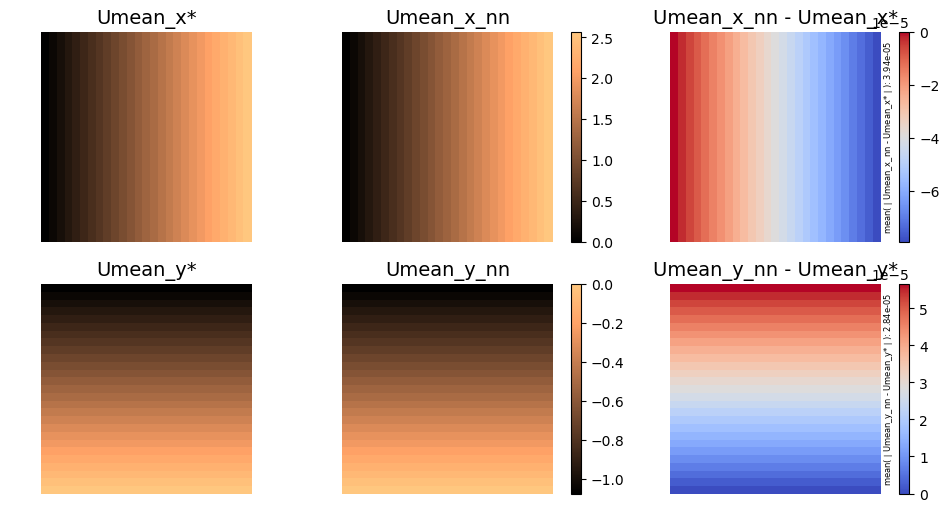

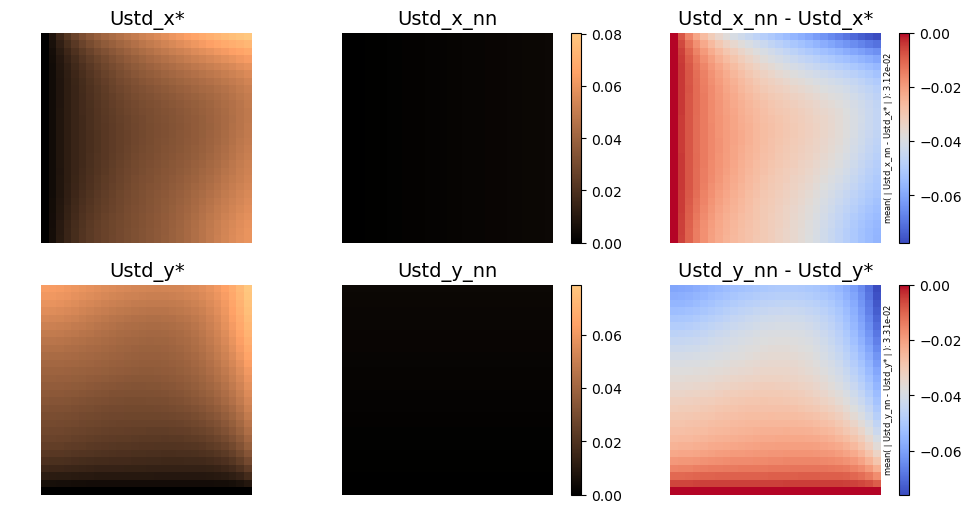

In [89]:
domain = [[0, Lmax], [0, Lmax]]
U_plot = lambda x: U_nn(x, xi[0], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)
U_mean_plot = lambda x: U_nn(x, torch.zeros_like(xi[0]), Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)
S_mean_plot = lambda x: S_nn(E_nn(U_mean_plot(x),x), np.exp(C11param[0]), np.exp(C33param[0]))

def U_std_plot(x):
    coeffs_x = [Enforce_BC(x,Ux_coeffs(x)[:,i],Uy_coeffs(x)[:,i])[0] for i in range(truncation_order)]
    coeffs_y = [Enforce_BC(x,Ux_coeffs(x)[:,i],Uy_coeffs(x)[:,i])[1] for i in range(truncation_order)]

    coeffs_x = torch.stack(coeffs_x,dim=1)
    coeffs_y = torch.stack(coeffs_y,dim=1)

    return [torch.sum(coeffs_x**2,dim=1)**0.5,torch.sum(coeffs_y**2,dim=1)**0.5]
        


# fig = plot_field(domain,U_mean_mc,V_exact=U_exact,plot_diff=True,fields_name="Umean_mc",N=28)
fig = plot_field(domain,U_mean_plot,V_exact=U_exact,plot_diff=True,fields_name="Umean")
# fig = plot_field(domain,U_mean_plot,fields_name="Umean")
# fig = plot_field(domain,S_mean_plot,fields_name="Smean")

# fig = plot_field(domain,U_std_mc,fields_name="Ustd",N=28)
fig = plot_field(domain,U_std_plot,V_exact=U_std_mc,plot_diff=True,fields_name="Ustd",N=28)
# fig = plot_field(domain,U_plot,V_exact=U_exact,plot_diff=True,fields_name="Usample")


In [47]:
N = 27
# Generate the grid for plotting
x_plot = np.linspace(0, Lmax, int(N))
y_plot = np.linspace(0, Lmax, int(N))
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Create a meshgrid of points
Xinput = np.column_stack((X_plot.ravel(), Y_plot.ravel()))
Xtorch = torch.tensor(Xinput).float().to(device)
Xtorch.requires_grad = True


Ux_mean_plot = Ux_mean(Xtorch).flatten()
Uy_mean_plot = Uy_mean(Xtorch).flatten()
Ux_coeffs_plot = Ux_coeffs(Xtorch).T
Uy_coeffs_plot = Uy_coeffs(Xtorch).T

Ux_mean_plot, Uy_mean_plot = Enforce_BC(Xtorch,Ux_mean_plot,Uy_mean_plot)
Ux_coeffs_plot, Uy_coeffs_plot = Enforce_BC(Xtorch,Ux_coeffs_plot,Uy_coeffs_plot)
Ux_std_plot = torch.sqrt(torch.sum(Ux_coeffs_plot**2, dim=0))
Uy_std_plot = torch.sqrt(torch.sum(Uy_coeffs_plot**2, dim=0))

C11_plot = C_data[0][0]*torch.ones_like(Ux_mean_plot)
C33_plot = C_data[3][0]*torch.ones_like(Ux_mean_plot)
C_data_plot = [C[0]*torch.ones_like(Ux_mean_plot) for C in C_data]

E_means = E_nn((Ux_mean_plot,Uy_mean_plot),Xtorch)
S_means = S_nn(E_means, C11_plot, C33_plot)

M_plot = compute_PDE(Xtorch, E_means, C_data_plot)
PDE_loss = M_plot[0]**2 + M_plot[1]**2
M_plot.append(PDE_loss)



for i in range(3):
    E_means[i] = E_means[i].reshape(N, N).cpu().detach().numpy()
    S_means[i] = S_means[i].reshape(N, N).cpu().detach().numpy()
    M_plot[i] = M_plot[i].reshape(N, N).cpu().detach().numpy()


Ux_mean_plot = Ux_mean_plot.reshape(N, N).cpu().detach().numpy()
Uy_mean_plot = Uy_mean_plot.reshape(N, N).cpu().detach().numpy()
Ux_std_plot = Ux_std_plot.reshape(N, N).cpu().detach().numpy()
Uy_std_plot = Uy_std_plot.reshape(N, N).cpu().detach().numpy()
# Reshape the predicted displacement to match the grid shape



with torch.no_grad():
    Ux_pred, Uy_pred = U_nn(Xtorch, xi[0], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)
Ux_pred = Ux_pred.reshape(N, N).cpu().numpy()
Uy_pred = Uy_pred.reshape(N, N).cpu().numpy()

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im


# pde_loss,bc_loss,residual_loss = compute_loss(x_pde,x_bcs, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data,C_data_bc, batch_size,pstress=p_stress)




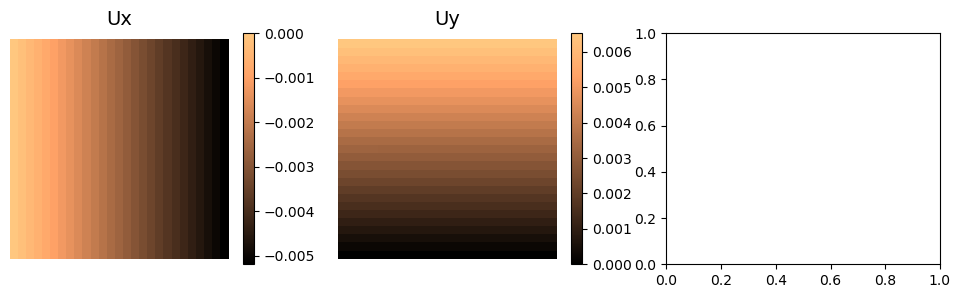

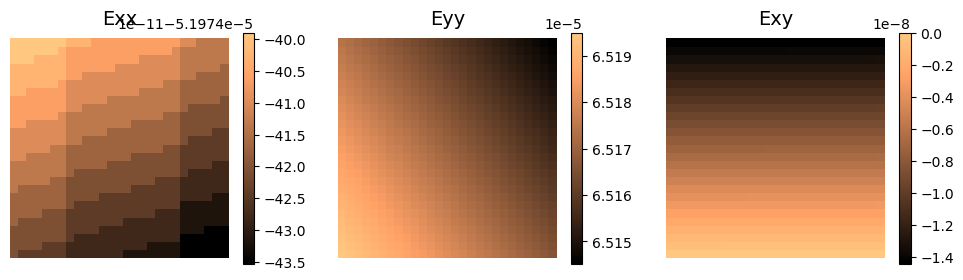

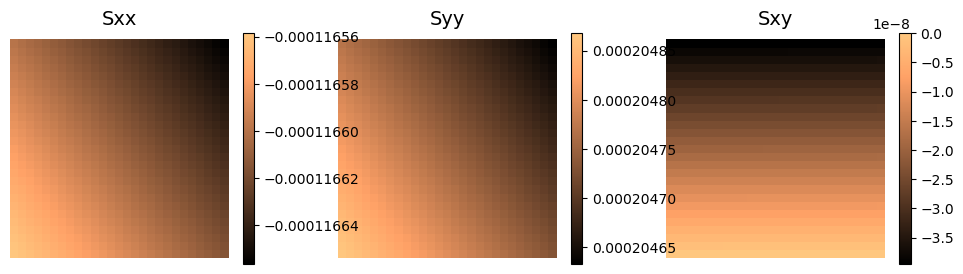

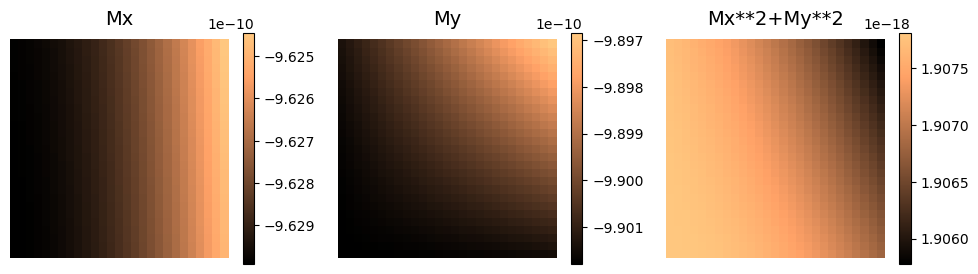

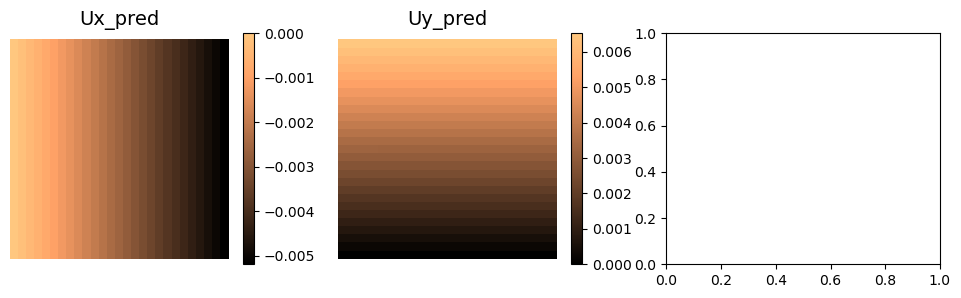

In [48]:
# fig,ax = plot_field(Mx_plot,My_plot)
# fig.suptitle('Mx', fontsize=24, y=1.05)

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

for i in range(2):
    im = pcolor_plot(ax[i], X_plot, Y_plot, [Ux_mean_plot, Uy_mean_plot][i],  ["Ux", "Uy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, E_means[i],  ["Exx", "Eyy", "Exy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, S_means[i],  ["Sxx", "Syy", "Sxy"][i])
    fig.colorbar(im, ax=ax[i])


fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, M_plot[i],  ["Mx", "My","Mx**2+My**2"][i])
    fig.colorbar(im, ax=ax[i])


fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

for i in range(2):
    im = pcolor_plot(ax[i], X_plot, Y_plot, [Ux_pred, Uy_pred][i],  ["Ux_pred", "Uy_pred"][i])
    fig.colorbar(im, ax=ax[i])

Mean: 1.208e-10, Std: 8.900e-11


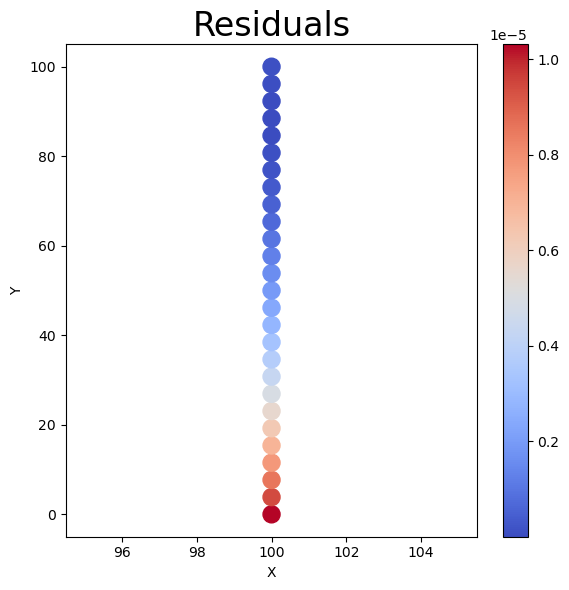

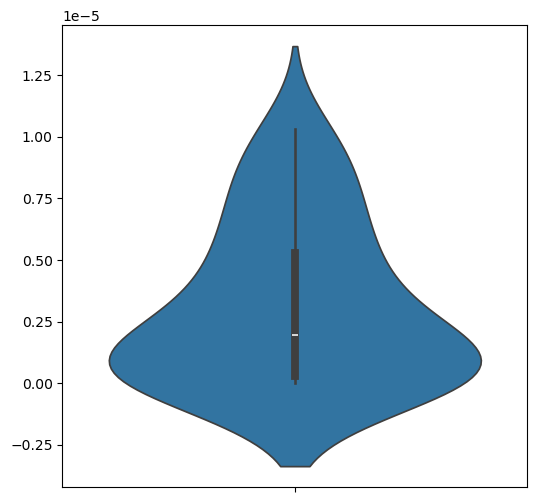

In [96]:
import seaborn as sns

def BC_residual(x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data,p_stress=0.1):
    """Compute the total predicted u."""
    Ux_stress = Ux_mean(x_bc[0]).flatten() #+ pce_basis @  Ux_coeffs(x_bc)
    Uy_stress = Uy_mean(x_bc[0]).flatten() #+ pce_basis @  Uy_coeffs(x_bc)
    Ux_stress, Uy_stress = Enforce_BC(x_bc[0],Ux_stress,Uy_stress)
    E_stress = E_nn((Ux_stress,Uy_stress),x_bc[0])

    Ux_free = Ux_mean(x_bc[1]).flatten() #+ pce_basis @  Ux_coeffs(x_bc)
    Uy_free = Uy_mean(x_bc[1]).flatten() #+ pce_basis @  Uy_coeffs(x_bc)
    Ux_free, Uy_free = Enforce_BC(x_bc[1],Ux_free,Uy_free)
    E_free = E_nn((Ux_free,Uy_free),x_bc[1])

    C11, dC11_dx, dC11_dy, C33, dC33_dx, dC33_dy = C_data
    C11 = C11.reshape(27,27)
    C33 = C33.reshape(27,27)
    C11_bc_stress = C11[:,-1]
    C33_bc_stress = C33[:,-1]
    C11_bc_free = C11[-1,:]
    C33_bc_free = C33[-1,:]
    S_stress = S_nn(E_stress, C11_bc_stress, C33_bc_stress)
    S_free = S_nn(E_free, C11_bc_free, C33_bc_free)

    bc_loss_stress = (S_stress[0] - p_stress)**2
    bc_loss_free = S_free[1]**2

    return (bc_loss_stress, bc_loss_free)

def plot_residuals(x_bc, BC_residual):
    """Plot the residuals at the boundary."""
    # Plot the heatmap of the predicted displacement
    x_bc = x_bc.detach().cpu().numpy()
    BC_residual = BC_residual.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    im1 = ax.scatter(x_bc[:, 0], x_bc[:, 1], c=BC_residual, s=150, cmap='coolwarm')
    plt.colorbar(im1,ax=ax)
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.set_title('Residuals',fontsize=24)
    plt.tight_layout()
    return fig,ax

x_bc_stress = torch.ones((N,2))*Lmax
x_bc_stress[:,1] = torch.linspace(0,Lmax,N).float()
x_bc_stress = x_bc_stress.to(device)
x_bc_stress.requires_grad = True

x_bc_free = torch.ones((N,2))*Lmax
x_bc_free[:,0] = torch.linspace(0,Lmax,N).float()
x_bc_free = x_bc_free.to(device)
x_bc_free.requires_grad = True

x_bc = [x_bc_stress,x_bc_free]

BC_residual = BC_residual(x_bc, xi[0], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data_plot)
fig,ax = plot_residuals(x_bc[0], BC_residual[0])

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

sns.violinplot(BC_residual[0].detach().cpu(), ax=ax)#, color="0.8")
print(f"Mean: {torch.mean(BC_residual[0]**2)+torch.mean(BC_residual[1]**2):.3e}, Std: {torch.std(BC_residual[0]**2+BC_residual[1]**2):.3e}")

ic| M_exact[2].mean(): 6.2017266e-23


6.2017266e-23

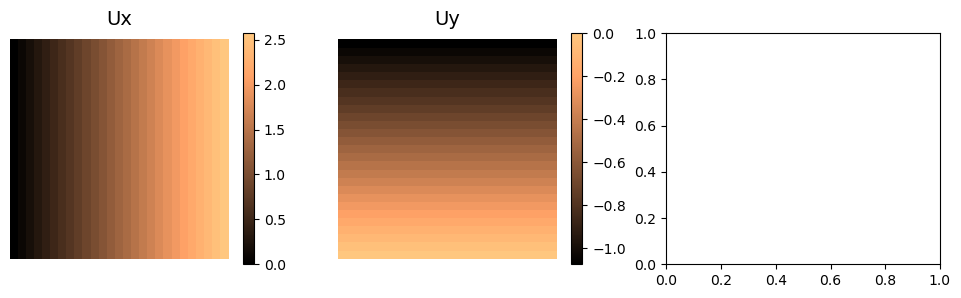

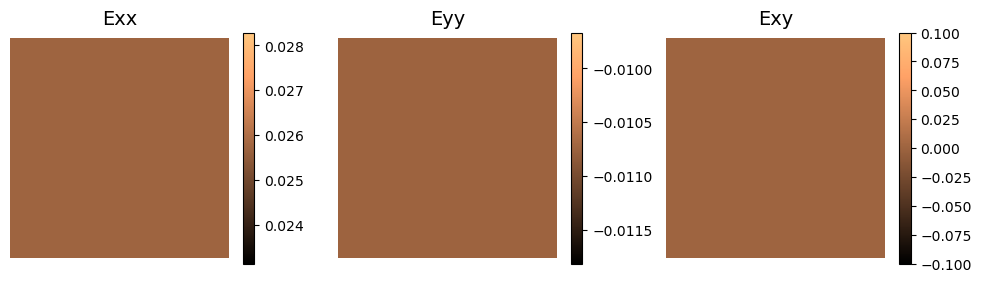

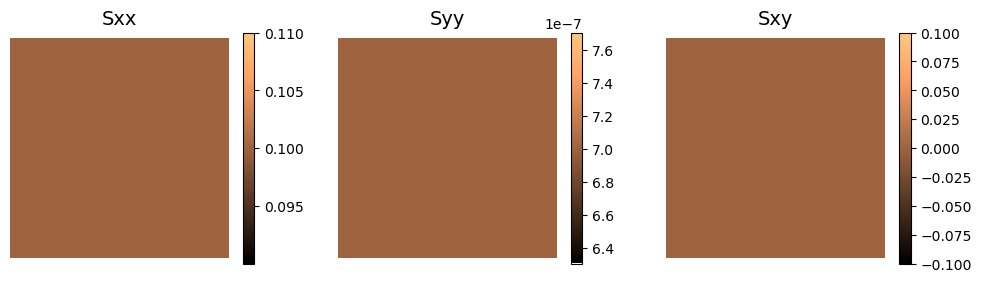

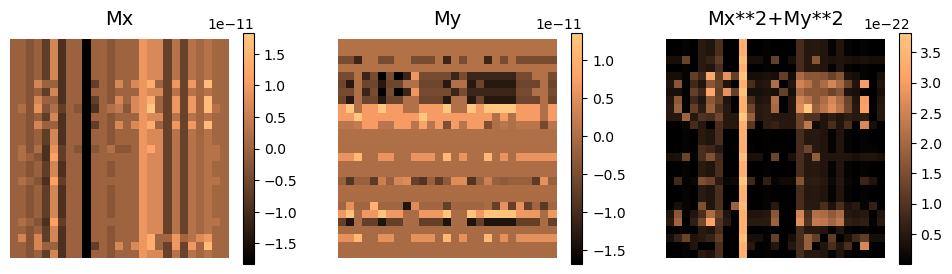

In [21]:
from icecream import ic
N = 27
# Generate the grid for plotting
x_plot = np.linspace(0, Lmax, int(N))
y_plot = np.linspace(0, Lmax, int(N))
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Create a meshgrid of points
Xinput = np.column_stack((X_plot.ravel(), Y_plot.ravel()))
Xtorch = torch.tensor(Xinput).float().to(device)
Xtorch.requires_grad = True

def u_exact(X,delta=1e-10):
    Ux = 0.025712*X[:,0]+delta*torch.cos(np.pi*X[:,0]/Lmax)
    Uy = -0.010741*X[:,1]+delta*torch.cos(np.pi*X[:,1]/Lmax)
    return [Ux,Uy]

C11_plot = C11[:,:,0].ravel()
C33_plot = C33[:,:,0].ravel()
C_data_plot = [C[:,:,0].ravel() for C in C_data]

U_exact = u_exact(Xtorch)
E_exact = E_nn(U_exact,Xtorch)
S_exact = S_nn(E_exact, C11_plot, C33_plot)
M_exact = compute_PDE(Xtorch, E_exact, C_data_plot)
PDE_loss = M_exact[0]**2 + M_exact[1]**2
M_exact.append(PDE_loss)


for i in range(3):
    if i<2:
        U_exact[i] = U_exact[i].reshape(N, N).cpu().detach().numpy()
    E_exact[i] = E_exact[i].reshape(N, N).cpu().detach().numpy()
    S_exact[i] = S_exact[i].reshape(N, N).cpu().detach().numpy()
    M_exact[i] = M_exact[i].reshape(N, N).cpu().detach().numpy()



fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(2):
    im = pcolor_plot(ax[i], X_plot, Y_plot, U_exact[i],  ["Ux", "Uy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, E_exact[i],  ["Exx", "Eyy", "Exy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, S_exact[i],  ["Sxx", "Syy", "Sxy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, M_exact[i],  ["Mx", "My","Mx**2+My**2"][i])
    fig.colorbar(im, ax=ax[i])

ic(M_exact[2].mean())